In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from math import log2, log10
import pickle
import cobra
import cobrame
from glob import glob
%matplotlib inline

/home/sbrg-cjlloyd/cobrapy/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


In [2]:
# Todo, allow shadow prices and reduced costs to be run at the same time

In [3]:
plt.rcParams['figure.figsize'] = [14.0, 6.0]
plt.rcParams['axes.labelsize'] = 17.0
plt.rcParams['xtick.labelsize'] = 13.0

In [4]:
with open('/home/sbrg-cjlloyd/multime/multime/iJL1678b_ML_keffs.pickle', 'rb') as f:
    me = pickle.load(f)

In [5]:
for file in glob('./production_at_5/fluxes.csv'):
    flux_df = pd.read_csv(file, index_col=0)
flux_df[abs(flux_df)<=1e-8] = 0
flux_df = flux_df.T[~ flux_df.columns.isin(['default'])].T
for i in flux_df.columns:
    flux_df.loc['production_flux', i] = flux_df.loc['EX_'+i+'_c', i]

In [17]:
for kind in ['shadow_wrt_target']:
    joined = pd.DataFrame()
    for file in glob('./production_at_5/%s.csv' % kind):
        df = pd.read_csv(file, index_col=0)
        joined = joined.join(df, how='outer')
joined[(joined <1e-8) & (joined>=0)] = 1e-8
joined[(joined >-1e-8) & (joined<=0)] = -1e-8
df = joined.T[~ joined.columns.isin(['default'])].T
default_series = joined['default']

In [18]:
norm_flux_df = (flux_df / flux_df.loc['production_flux']).drop('thm', axis=1)
norm_df = (df / flux_df.loc['production_flux']).drop('thm', axis=1)

In [19]:
change_shadow = (norm_df.T / norm_df.T.median())

In [16]:
keep_list = []
for i in change_shadow.columns:
    if i not in me.reactions:
        continue
    elif isinstance(me.reactions.get_by_id(i), cobrame.MetabolicReaction):
        keep_list.append(i)
change_shadow = change_shadow[keep_list]

In [21]:
keep_list = []
for i in change_shadow.columns:
    if i not in me.metabolites:
        continue
    elif isinstance(me.metabolites.get_by_id(i), cobrame.Complex):
        keep_list.append(i)
change_shadow = change_shadow[keep_list]
df = df.T[keep_list]

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook.py:136 MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.


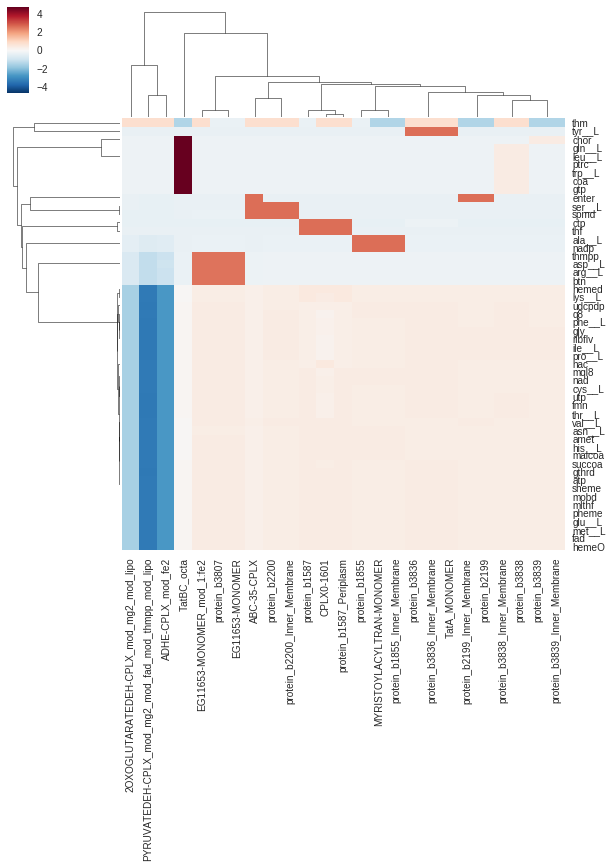

In [17]:
import seaborn as sns
new = change_shadow
new = change_shadow[change_shadow.std().sort_values(ascending=False)[:25].index]
g = sns.clustermap(new, z_score=0)
_ = plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0) 

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook.py:136 MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.


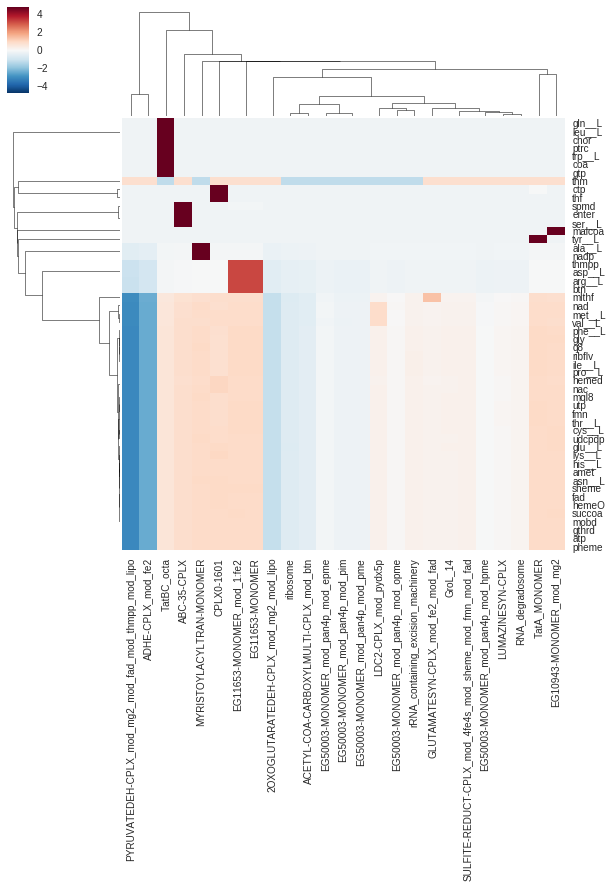

In [23]:
import seaborn as sns
new = df
new = df[df.std().sort_values(ascending=False)[:25].index]
g = sns.clustermap(new, z_score=0)
_ = plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0) 

In [158]:
iml = cobra.io.load_json_model('/home/sbrg-cjlloyd/Desktop/ecoli_M_models/iML1515.json')
flux_df.loc['me_glucose_yield'] = flux_df.loc['production_flux'] / abs(flux_df.loc['EX_glc__D_e'])
for i in flux_df.columns:
    test = iml.copy()
    if i+'_c' not in test.metabolites:
        syn = 0
    else:
        r = cobra.Reaction('EX_%s_c' % i)
        test.add_reaction(r)
        r.add_metabolites({i + '_c': -1})
        test.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = .5
        test.objective =r
        test.reactions.get_by_id('EX_glc__D_e').lower_bound = flux_df.loc['EX_glc__D_e', i]
        syn = test.optimize().f
    flux_df.loc['m_glucose_yield', i] = syn / 10


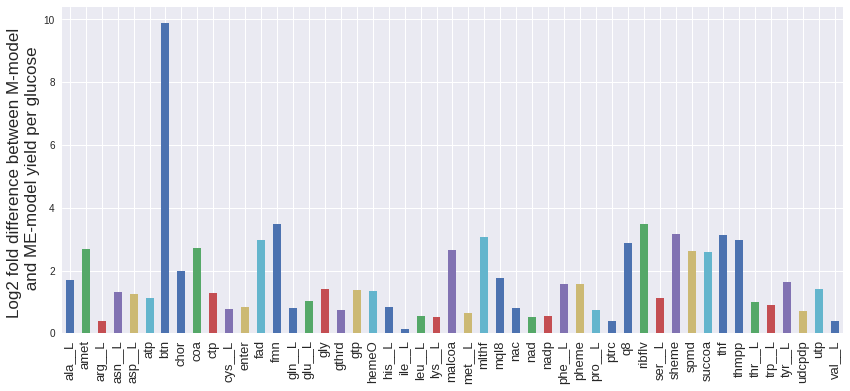

In [137]:
ax = (flux_df.loc['m_glucose_yield'].map(log2) - flux_df.loc['me_glucose_yield'].map(log2) ).plot(kind='bar')
ax.set_ylabel('Log2 fold difference between M-model \n and ME-model yield per glucose')

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook.py:136 MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.


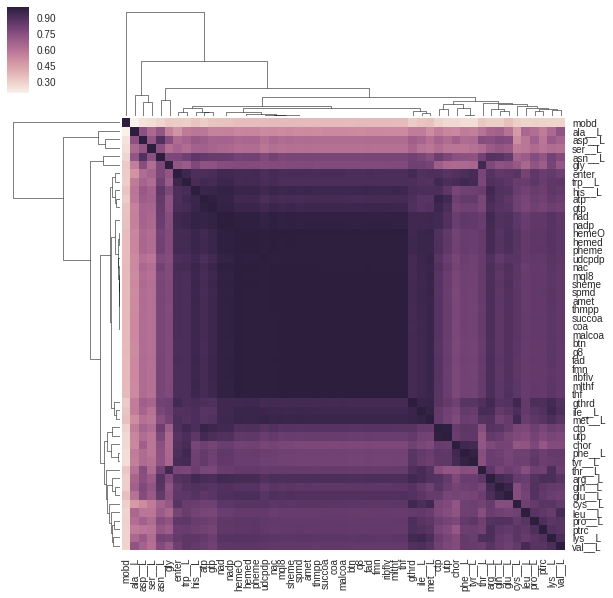

In [13]:
g = sns.clustermap(norm_flux_df.corr()**2)
_ = plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0) 

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook.py:136 MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.


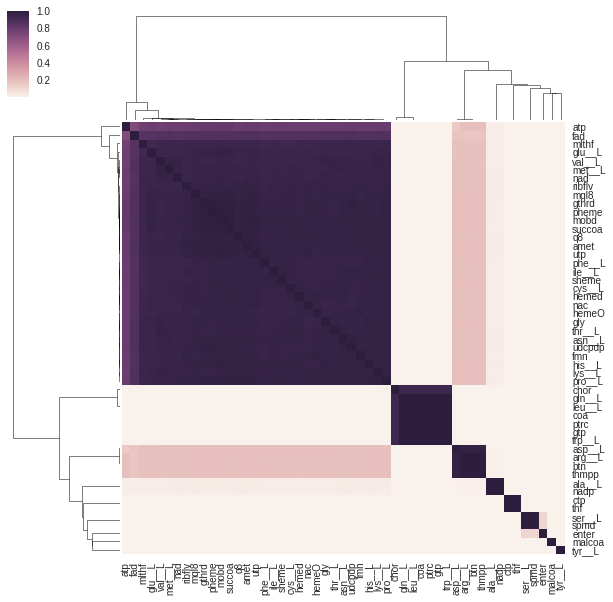

In [14]:
# Comparing correlations
g = sns.clustermap(norm_df.corr()**2)
_ = plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0) 

In [25]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
pca_df = norm_flux_df.fillna(0)
pca_df.drop(['mobd'], axis=1, inplace=True)
expression_values = preprocessing.StandardScaler().fit_transform(pca_df.T)
#expression_values = pca_df
#expression_values = zscore(filtered_df.T, axis=1)
pca = PCA(n_components=5)
a = pca.fit(expression_values)
len(a.components_[0])

print(pca.explained_variance_ratio_)

rxns =pca_df.T.columns
mets = pca_df.T.index
X_r = pca.fit(expression_values).transform(expression_values)

component_dict = {}
for comp_num in [0, 1, 2]:
    comp = a.components_[comp_num]
    component_dict['positive_%s' % comp_num] =  dict(zip(rxns[comp > (abs(comp.mean()) + 1 * comp.std())].values, comp[comp > (abs(comp.mean()) + 2 * comp.std())]))
    component_dict['negative_%s' % comp_num] =  dict(zip(rxns[comp < -(abs(comp.mean()) + 1 * comp.std())].values, comp[comp < -(abs(comp.mean()) + 2 * comp.std())]))

component_df = pd.DataFrame(component_dict).fillna(0)
for i in component_df.index:
    component_df.loc[i, 'min'] = pca_df.loc[i].min()
    component_df.loc[i, 'max'] = pca_df.loc[i].max()
    component_df.loc[i, 'avg'] = pca_df.loc[i].mean()
component_df.to_csv('/home/sbrg-cjlloyd/Desktop/test.csv')

[0.70060803 0.02820452 0.02500155 0.02131901 0.01739817]


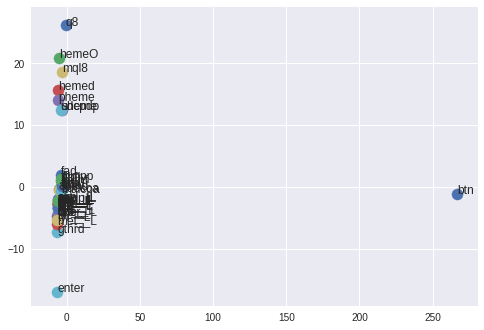

In [26]:
fig, ax = plt.subplots()
for i, met in enumerate(mets):
    #if met in ['thf', 'nac']:
    ax.text(X_r[i, 0], X_r[i, 1], met)
    ax.scatter(X_r[i, 0], X_r[i, 1], s=125)

In [27]:
component_df.sort_values('positive_1', ascending=True)

,negative_0,negative_1,negative_2,positive_0,positive_1,positive_2,min,max,avg
2AGPE160tipp_FWD_EG12455-MONOMER,0.0,0.0,0.000000,0.026198,0.000000,0.000000,3.399320e-05,1.637120e+01,3.535902e-01
formation_SUCCORNTRANSAM-CPLX_mod_pydx5p,0.0,0.0,0.000000,0.026198,0.000000,0.000000,5.335437e-08,2.812437e-02,6.066042e-04
formation_SUCCCOASYN,0.0,0.0,0.000000,0.026198,0.000000,0.000000,1.535457e-07,7.287991e-02,1.573489e-03
formation_SRP-CPLX,0.0,0.0,0.000000,0.026198,0.000000,0.000000,9.853612e-09,3.640282e-03,7.866248e-05
formation_SAICARSYN-CPLX,0.0,0.0,0.000000,0.026199,0.000000,0.000000,1.105590e-07,5.513651e-02,1.205359e-03
formation_Rrf_mono,0.0,0.0,0.000000,0.026198,0.000000,0.000000,4.429762e-10,2.384126e-04,5.150066e-06
formation_RpsU_mono,0.0,0.0,0.000000,0.026198,0.000000,0.000000,7.110963e-07,3.452377e-01,7.452696e-03
formation_RpsT_mono,0.0,0.0,0.000000,0.026198,0.000000,0.000000,7.110963e-07,3.452377e-01,7.452696e-03
formation_RpsS_mono,0.0,0.0,0.000000,0.026198,0.000000,0.000000,7.110963e-07,3.452377e-01,7.452696e-03
formation_RpsR_mono,0.0,0.0,0.000000,0.026198,0.000000,0.000000,7.110963e-07,3.452377e-01,7.452696e-03
